In [2]:
import os
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from scipy.io import savemat, loadmat

from my_utils import models
from my_utils.utils import save_model, check_accuracy, train
from my_utils.vis import *

from data.loader import load_frames
from data.preprocess import sub_mean, reduce
from data import dataset

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [3]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{0}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:0 now!


In [60]:
png_dir = '/mnt/cfs/wangyh/blender/output_png/output_Jump_Sophie_CYCLES_s1024_r256/'

In [ ]:
frames_wall = load_frames(root=png_dir,
                          frame_range=None,
                          output_size=None).to(device)

In [54]:
frames_people = load_frames(root="/home/wangyh/01-Projects/04-blender/blank_wall/output_dance_people",
                            frame_range=(0, 10),
                            output_size=(540, 960))

In [61]:
print(frames_wall.shape)
# print(frames_people.shape)

torch.Size([64, 256, 256, 4])


In [62]:
save_dict = {"frames":frames_wall.cpu().numpy()}

In [8]:
import stat

os.chmod(path='/mnt/cfs/wangyh/',
         mode=stat.S_IWOTH)

In [63]:
savemat(png_dir+'frames.mat', save_dict)

In [64]:
loaded = loadmat(png_dir + 'frames.mat')

In [65]:
frames_wall = loaded["frames"]
# frames_people = loaded["people"]

In [66]:
frames_wall

array([[[[154., 148., 140., 255.],
         [162., 154., 147., 255.],
         [161., 154., 148., 255.],
         ...,
         [146., 132., 123., 255.],
         [142., 130., 118., 255.],
         [120., 107., 100., 255.]],

        [[163., 153., 149., 255.],
         [159., 150., 143., 255.],
         [160., 151., 145., 255.],
         ...,
         [145., 129., 121., 255.],
         [147., 132., 124., 255.],
         [135., 120., 116., 255.]],

        [[158., 149., 145., 255.],
         [160., 153., 145., 255.],
         [159., 150., 145., 255.],
         ...,
         [145., 131., 123., 255.],
         [145., 131., 119., 255.],
         [136., 121., 113., 255.]],

        ...,

        [[163., 151., 146., 255.],
         [162., 152., 145., 255.],
         [163., 152., 145., 255.],
         ...,
         [166., 155., 149., 255.],
         [167., 157., 150., 255.],
         [157., 147., 142., 255.]],

        [[163., 151., 146., 255.],
         [162., 151., 144., 255.],
         [16

In [67]:
print(frames_wall.shape)
# print(frames_people.shape)

(64, 256, 256, 4)


In [68]:
frames_sub_mean = sub_mean(torch.from_numpy(frames_wall))

In [69]:
frames_sub_mean

tensor([[[[-0.1719,  0.5000,  0.3594],
          [ 0.5156,  1.0625,  0.4375],
          [ 0.1562,  1.0781,  0.4219],
          ...,
          [ 0.4531,  0.3281,  0.2656],
          [-0.2188, -0.0625, -0.3750],
          [-0.6406,  0.2031,  0.0781]],

         [[-0.4375, -0.0312,  0.2969],
          [-0.5469,  0.0938,  0.8281],
          [-0.2500,  0.1562, -0.3594],
          ...,
          [ 0.1094,  0.2500,  0.4688],
          [-0.2344, -0.6094,  0.6875],
          [-1.0156, -0.1875, -0.6250]],

         [[-0.4531, -0.0312,  0.3125],
          [-0.7969,  0.0312, -0.8750],
          [-0.3594,  0.0469, -0.0938],
          ...,
          [-0.0938,  0.4531,  0.6562],
          [ 0.0312, -0.1250, -0.3594],
          [-0.5312, -0.9844, -0.8438]],

         ...,

         [[ 0.3750, -0.6094,  0.2344],
          [ 0.0000,  0.0625, -0.0312],
          [ 0.1562, -0.2031, -0.1250],
          ...,
          [ 0.0000,  0.0000,  0.0000],
          [ 0.1875,  0.1406,  0.8750],
          [ 0.7188,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


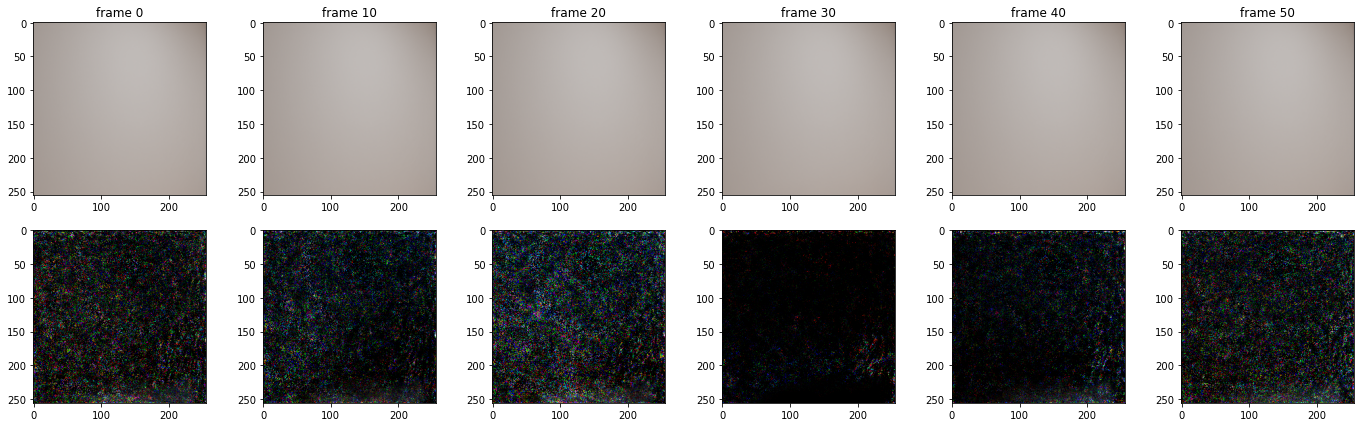

In [70]:
sample_num = 6
fig, axs = plt.subplots(2, sample_num, figsize=(4 * sample_num, 7))
for i in range(sample_num):
    idx = 10 * i
    # axs[0, i].imshow(frames_people[i] / 255.)
    axs[0, i].imshow(frames_wall[idx] / 255.)
    axs[0, i].set_title(f'frame {idx}')
    axs[1, i].imshow(frames_sub_mean[idx])

In [71]:
image_reduce_H, image_reduce_W = reduce(frames_sub_mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


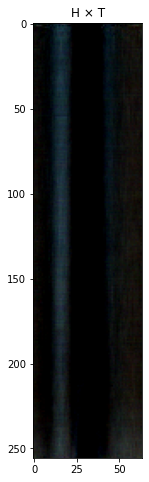

In [72]:
plt.imshow(image_reduce_W)
plt.title("H × T")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


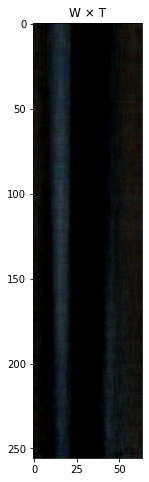

In [73]:
plt.imshow(image_reduce_H)
plt.title("W × T")
plt.show()